In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

from tqdm import tqdm

# Data Loading

In [2]:
locations = [
    "Beach Road",
    "Curran Street",
    "East Coast Road",
    "Grafton Bridge",
    "Grafton Gully",
    "Grafton Road",
    "Great South Road",
    "Highbrook shared path",
    "Hopetoun Street",
    "Karangahape Road",
    "Lagoon Drive",
    "Lake Road",
    "Lightpath",
    "Mangere Bridge",
    "Northwestern cycleway – Kingsland",
    "Northwestern cycleway – Te Atatu",
    "Orewa shared path",
    "Quay St (Vector Arena)",
    "SH20 shared path (near Dominion Road)",
    "Symonds Street",
    "Tamaki Drive (both sides of the road)",
    "Te Wero Bridge (Wynyard Quarter)",
    "Twin Streams shared path",
    "Upper Harbour Drive",
    "Upper Queen Street",
    "Victoria St West",
]

In [ ]:
LOCATION_MAPPING = {
    "Great North Road NB Towards CBD": "Great North Road",
    "Great South Road Manukau": "Great South Road",
    "Highbrook Pathway": "Highbrook Drive",
    "Lake Road Total New": "Lake Road",
    "Leigh Road Shared Path": "Leigh Road",
    "Mangere Foot Bridge": "Mangere Bridge",
    "Ocean View Rd": "Oceanview Road",
    "Rathgar Road": "Rathger Road",
    "Remuera Road": "Remurua Road",
    "SH20A Shared Path": "SH20A",
    "SW Shared Path": "SH18 Upper Harbour Drive",
    "Symonds Street Total": "Symonds Street",
    "Tamaki Drive - Parnell": "Tamaki Drive",
    "TeAtatu Peninsula Shared Path": "TeAtatu Peninsula",
    "TeWero Bridge Bike Counter": "TeWero Bridge",
    "Ti Rakau - Opposite Bunnings": "Ti Rakau",
    "Ti Rakau opposite 92": "Ti Rakau",
    "Twin Streams Shared Path": "Twin Streams",
    "Waterview Unitec Shared Path": "Waterview Unitec",
}

In [4]:
BIKE_COUNT_URLS_AND_LOAD_KWARGS = [
    ("https://at.govt.nz/media/1991027/auckland-trasnport-cycle-counts-jan-dec-2022.xlsx", {}),
    ("https://at.govt.nz/media/1991376/auckland-transport-january-2023-cycle-counts.xlsx", {}),
    ("https://at.govt.nz/media/1991377/auckland-transport-february-2023-cycle-counts.xlsx", {}),
    ("https://at.govt.nz/media/1991436/auckland-transport-march-2023-cycle-counts.xlsx", {}),
    ("https://at.govt.nz/media/1992545/april-2023-cycle-counts.xlsx", {}),
    ("https://at.govt.nz/media/1992547/may-2023-cycle-counts.xlsx", {}),
    ("https://at.govt.nz/media/1992546/june-2023-cycle-counts.xlsx", {}),
    ("https://at.govt.nz/media/xs5lybun/at-daily-cycle-data-july-2023.xlsx", {"header": 2}),
    ("https://at.govt.nz/media/t3zlbdn4/at-daily-cycle-data-august-2023.xlsx", {"header": 2}),
    ("https://at.govt.nz/media/53rj40ji/at-daily-cycle-data-september-2023.xlsx", {"header": 2}),
    ("https://at.govt.nz/media/hl0jbsrl/at-daily-cycle-data-october-2023.xlsx", {"header": 2}),
    ("https://at.govt.nz/media/ty4js45t/at-daily-cycle-counts-november-2023.xlsx", {"header": 2}),
    ("https://at.govt.nz/media/1tvdgsgo/at-daily-cycle-counts-december-2023.xlsx", {"header": 2}),
    ("https://at.govt.nz/media/bb4h3wd3/at-daily-cycle-counts-january-2024.xlsx", {"header": 2}),
    ("https://at.govt.nz/media/xlcaru0v/at-daily-cycle-counts-feb-2024.xlsx", {"header": 2}),
    ("https://at.govt.nz/media/4g3hzpp5/at-daily-cycle-counts-march-2024.xlsx", {"header": 2}),
    ("https://at.govt.nz/media/htvezqdn/at-daily-cycle-counts-april-2024.xlsx", {"header": 2}),
    ("https://at.govt.nz/media/ue5cygl0/at-daily-cycle-counts-may-2024.xlsx", {"header": 2}),
    ("https://at.govt.nz/media/3icd2jug/at-daily-cycle-counts-june-2024.xlsx", {"header": 2}),
    ("https://at.govt.nz/media/jbdd1rox/cycle-counts-july-2024.xlsx", {"header": 2, "na_values": "z"}),
    ("https://at.govt.nz/media/bvadzmqg/cycle-counts-august-2024.xlsx", {"usecols": "G:CG"}),
    ("https://at.govt.nz/media/lpsfdwbe/auckland-transport-cycle-counts-september-2024.xlsx", {"usecols": "G:CG"}),
    ("https://at.govt.nz/media/ohbhvmrl/auckland-transport-cycle-movements-october-2024.xlsx", {"header": 2}),
    ("https://at.govt.nz/media/chelni1f/auckland-transport-cycle-movements-data-november-2024.xlsx", {"header": 2}),
    ("https://at.govt.nz/media/zdumuud2/auckland-transport-cycle-movements-december-2024.xlsx", {"header": 2}),
]

In [5]:
def load_cycle_counts(url: str, **read_excel_kwargs) -> pd.DataFrame:
    df = pd.read_excel(url, **read_excel_kwargs)
    df = df.rename(columns={"Date": "date", "Date.1": "date", "Time": "date"})
    df = df.melt(id_vars="date", var_name="location", value_name="count")
    return df


def standardise_locations(df: pd.DataFrame) -> pd.DataFrame:
    df["location"] = df["location"].str.replace(r" Cyclists?", "", regex=True)
    df["location"] = df["location"].str.replace(r"\bDr\b", "Drive", regex=True)
    df["location"] = df["location"].str.replace(r"\bRd\b", "Road", regex=True)
    df["location"] = df["location"].str.replace(r"\bSt\b", "Street", regex=True)

    return df

In [6]:
dfs = []
for url, load_kwargs in tqdm(BIKE_COUNT_URLS_AND_LOAD_KWARGS):
    try:
        df = load_cycle_counts(url, **load_kwargs)
    except Exception as e:
        print("Could not load data for url: ", url)
        print("Reason: ", e)
        continue
    dfs.append(df)

cycle_counts = pd.concat(dfs, axis=0, ignore_index=True)

In [7]:
cycle_counts = standardise_locations(cycle_counts)

In [9]:
sorted(cycle_counts["location"].unique())

['Albany Highway',
 'Archibald Park',
 'Beach Road',
 'Carlton Gore Road',
 'Coronation Road',
 'Curran Street',
 'Dominion Road',
 'East Coast Road',
 'Franklin Road',
 'GI TO TAMAKI DR SECTION-1',
 'GI to Tamaki Drive Section-2',
 'Grafton Bridge',
 'Grafton Gully',
 'Grafton Road',
 'Great North Road',
 'Great North Road NB Towards CBD',
 'Great South Road',
 'Great South Road Manukau',
 'Green Lane West',
 'Gt Sth Road - Ellerslie',
 'Hendry Avenue',
 'Highbrook Drive',
 'Highbrook Pathway',
 'Hobsonville Point Road',
 'Hobsonville Road',
 'Hopetoun Street',
 'Karangahape Road',
 'Lagoon Drive',
 'Lake Road',
 'Lake Road Northcote',
 'Lake Road Total New',
 'Leigh Road',
 'Leigh Road Shared Path',
 'Lightpath',
 'Mahia Road',
 'Mangere Bridge',
 'Mangere Foot Bridge',
 'Mangere Safe Routes',
 'Manukau Road',
 'Meadowbank SUP',
 'Mount Albert Road',
 'Mount Eden Road',
 'Mt Smart Road',
 'Mt Wellington Hwy',
 'NW Cycleway Kingsland',
 'NW Cycleway TeAtatu',
 'Nelson Street',
 'New L

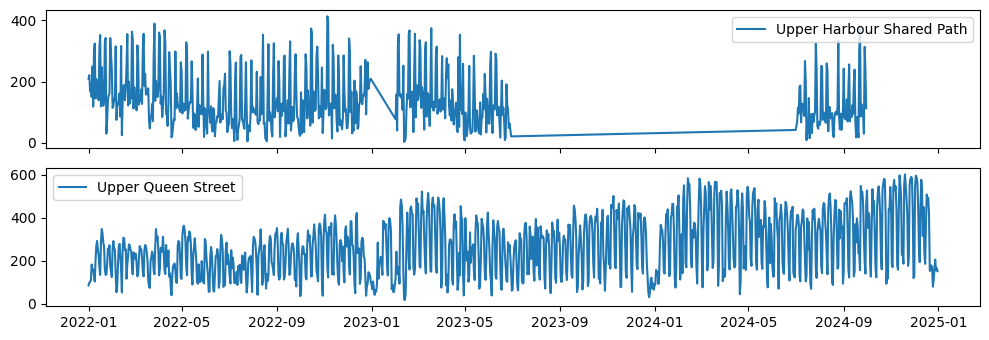

In [40]:
locs = [
 'Upper Harbour Shared Path',
 'Upper Queen Street'
]
fig, ax = plt.subplots(len(locs), 1, figsize=(10, len(locs) * 1.75), sharex=True)
for i, loc in enumerate(locs):
    location_df = cycle_counts[cycle_counts["location"] == loc].sort_values("date")
    ax[i].plot(
        location_df["date"].values,
        location_df["count"].values,
        label=loc
    )
    ax[i].legend()

fig.tight_layout();

In [ ]:
# 2022 data
url_2022 = "https://at.govt.nz/media/1991027/auckland-trasnport-cycle-counts-jan-dec-2022.xlsx"

df = pd.read_excel(url_2022)
df = df.melt(id_vars=["Date"], var_name="location", value_name="count")
df = df.rename(columns={"Date": "date"})


In [ ]:
# 2023 data first part
url = "https://at.govt.nz/media/1991376/auckland-transport-january-2023-cycle-counts.xlsx"
url = "https://at.govt.nz/media/1991377/auckland-transport-february-2023-cycle-counts.xlsx"
url = "https://at.govt.nz/media/1991436/auckland-transport-march-2023-cycle-counts.xlsx"
url = "https://at.govt.nz/media/1992545/april-2023-cycle-counts.xlsx"
url = "https://at.govt.nz/media/1992547/may-2023-cycle-counts.xlsx"
url = "https://at.govt.nz/media/1992546/june-2023-cycle-counts.xlsx"

df = pd.read_excel(url)
df = df.melt(id_vars="Time", var_name="location", value_name="count")
df = df.rename(columns={"Time": "date"})
df["location"] = df["location"].str.replace(r" Cyclists?", "", regex=True)
df["location"] = df["location"].str.replace(r"\bDr\b", "Drive", regex=True)
df["location"] = df["location"].str.replace(r"\bRd\b", "Road", regex=True)
df["location"] = df["location"].str.replace(r"\bSt\b", "Street", regex=True)


In [ ]:
# 2023 data second part
url = "https://at.govt.nz/media/xs5lybun/at-daily-cycle-data-july-2023.xlsx"
url = "https://at.govt.nz/media/t3zlbdn4/at-daily-cycle-data-august-2023.xlsx"
url = "https://at.govt.nz/media/53rj40ji/at-daily-cycle-data-september-2023.xlsx"
url = "https://at.govt.nz/media/hl0jbsrl/at-daily-cycle-data-october-2023.xlsx"
url = "https://at.govt.nz/media/ty4js45t/at-daily-cycle-counts-november-2023.xlsx"
url = "https://at.govt.nz/media/1tvdgsgo/at-daily-cycle-counts-december-2023.xlsx"

df = pd.read_excel(url, header=2)
df = df.melt(id_vars="Time", var_name="location", value_name="count")
df = df.rename(columns={"Time": "date"})
df["location"] = df["location"].str.replace(r" Cyclists?", "", regex=True)
df["location"] = df["location"].str.replace(r"\bDr\b", "Drive", regex=True)
df["location"] = df["location"].str.replace(r"\bRd\b", "Road", regex=True)
df["location"] = df["location"].str.replace(r"\bSt\b", "Street", regex=True)

In [ ]:
# 2024 data first part
url = "https://at.govt.nz/media/bb4h3wd3/at-daily-cycle-counts-january-2024.xlsx"
url = "https://at.govt.nz/media/xlcaru0v/at-daily-cycle-counts-feb-2024.xlsx"
url = "https://at.govt.nz/media/4g3hzpp5/at-daily-cycle-counts-march-2024.xlsx"
url = "https://at.govt.nz/media/htvezqdn/at-daily-cycle-counts-april-2024.xlsx"
url = "https://at.govt.nz/media/ue5cygl0/at-daily-cycle-counts-may-2024.xlsx"
url = "https://at.govt.nz/media/3icd2jug/at-daily-cycle-counts-june-2024.xlsx"
url = "https://at.govt.nz/media/jbdd1rox/cycle-counts-july-2024.xlsx"

df = pd.read_excel(url, header=2)
id_var = "Date" if "Date" in df.columns else "Time"
df = df.melt(id_vars=id_var, var_name="location", value_name="count")
df = df.rename(columns={id_var: "date"})
df["location"] = df["location"].str.replace(r" Cyclists?", "", regex=True)
df["location"] = df["location"].str.replace(r"\bDr\b", "Drive", regex=True)
df["location"] = df["location"].str.replace(r"\bRd\b", "Road", regex=True)
df["location"] = df["location"].str.replace(r"\bSt\b", "Street", regex=True)

In [ ]:
url = "https://at.govt.nz/media/bvadzmqg/cycle-counts-august-2024.xlsx"
url = "https://at.govt.nz/media/lpsfdwbe/auckland-transport-cycle-counts-september-2024.xlsx"

df = pd.read_excel(url, usecols="G:CG")
df = df.rename(columns={"Date": "date", "Date.1": "date", "Time": "date"})
df = df.melt(id_vars="date", var_name="location", value_name="count")

In [ ]:
url = "https://at.govt.nz/media/ohbhvmrl/auckland-transport-cycle-movements-october-2024.xlsx"
url = "https://at.govt.nz/media/chelni1f/auckland-transport-cycle-movements-data-november-2024.xlsx"
url = "https://at.govt.nz/media/zdumuud2/auckland-transport-cycle-movements-december-2024.xlsx"


df = pd.read_excel(url, header=2)
df = df.rename(columns={"Date": "date", "Date.1": "date", "Time": "date"})
df = df.melt(id_vars="date", var_name="location", value_name="count")

In [ ]:
cycle_counts.to_csv("cycle_counts.csv", index=False)

In [ ]:
cycle_counts = pd.read_csv("cycle_counts.csv", parse_dates=["time"])

## EDA

### Total counts by day

In [ ]:
daily_total = cycle_counts.groupby("time")[["count"]].sum().reset_index()

fig, ax = plt.subplots(1, 2, figsize=(10, 3.5))

ax[0].plot(daily_total["time"], daily_total["count"])
ax[0].set(ylabel="Count")
for tick in ax[0].get_xticklabels():
    tick.set_rotation(45)

ax[1].hist(daily_total["count"], bins=20);
ax[1].set(xlabel="Count", ylabel="Frequency")

fig.tight_layout()

### Daily counts by location

In [ ]:
av_daily_counts = cycle_counts.groupby("time")[["count"]].mean().reset_index()

fig, ax = plt.subplots(2, 1, figsize=(12, 5), sharex=True)

locations = cycle_counts["location"].unique()
for location in locations:
    location_df = cycle_counts[cycle_counts["location"] == location]
    ax[0].plot(location_df["time"], location_df["count"], color="gray", alpha=0.5)
    ax[1].plot(location_df["time"], np.log1p(location_df["count"]), color="gray", alpha=0.5)

ax[0].plot(av_daily_counts["time"], av_daily_counts["count"], color="blue", linewidth=2)
ax[1].plot(av_daily_counts["time"], np.log1p(av_daily_counts["count"]), color="blue", linewidth=2)

ax[0].set(ylabel="Count")
ax[1].set(ylabel="Log(Count)")

In [ ]:
av_daily_counts_by_loc = cycle_counts.groupby("location")[["count"]].mean().reset_index()
av_daily_counts_by_loc = av_daily_counts_by_loc.sort_values("count").reset_index(drop=True)

mean_counts = av_daily_counts_by_loc["count"].mean()
median_counts = av_daily_counts_by_loc["count"].median()

fig, ax = plt.subplots(1, 1)
ax.hist(av_daily_counts_by_loc["count"], bins=20)
ax.axvline(mean_counts, color="red", linestyle="--", lw=2.5, label="Mean")
ax.axvline(median_counts, color="orange", linestyle="--", lw=2.5, label="Median")
ax.set(xlabel="Average Daily Count", ylabel="Frequency")
ax.legend();

### High demand locations

In [ ]:
threshold = 600
high_demand_locs = av_daily_counts_by_loc[av_daily_counts_by_loc["count"] > threshold]
high_demand_locs.sort_values("count")

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

locations = high_demand_locs["location"].values
colors = cm.coolwarm(np.linspace(0, 1, len(locations)))
for i, location in enumerate(locations):
    location_df = cycle_counts[cycle_counts["location"] == location]
    ax.plot(
        location_df["time"],
        location_df["count"],
        label=location,
        color=colors[i],
        lw=2.5,
    )
ax.set(ylabel="Count")
fig.tight_layout();

In [ ]:
counts_pivot = cycle_counts.pivot_table(columns="time", index="location", values="count", aggfunc="sum")
counts_pivot = counts_pivot.fillna(0).assign(average=lambda x: x.mean(axis=1))
counts_pivot = counts_pivot[counts_pivot["average"].between(200, 2500)]
counts_pivot = counts_pivot.sort_values("average", ascending=False).drop(columns="average")

fig, ax = plt.subplots(1, 1)
sns.heatmap(counts_pivot, cmap="coolwarm", cbar_kws={"label": "Count"})

xs = np.arange(0, counts_pivot.shape[1], 10)
xticklables = [c.strftime("%Y-%m-%d") for c in counts_pivot.columns[xs]]
ax.set(xticks=xs, xticklabels=xticklables)

ys = np.arange(0, counts_pivot.shape[0])
yticklables = counts_pivot.index[ys]
ax.set_yticks(ys + 0.5)
ax.set_yticklabels(yticklables, fontsize="small")

ax.set(xlabel="", ylabel="");